In [1]:
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import sqlite3
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from collections import defaultdict
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score

from xgboost import XGBRegressor

In [2]:
def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        output = frac_str[:-1]
        
        if output=='+':
            return 0.5
        elif output=='-':
            return -0.5
        
        if output[0]=='-':
            output = float(output) - 0.5
        elif output[0]=='+':
            output = float(output) + 0.5
        return output

In [20]:
def calc_bet_winning_percentages(df):
    spread_wl_1 = []
    spread_wl_2 = []
    spread_wl_4 = []
    for row in df.iterrows():
        row = row[1]
        if row['SPREADS_PRED'] > row['SPREAD_1_AWAY']:
            if row['SPREAD'] > row['SPREAD_1_AWAY']:
                spread_wl_1.append(1)
            elif row['SPREAD'] < row['SPREAD_1_AWAY']:
                spread_wl_1.append(0)
                
        elif row['SPREADS_PRED'] < row['SPREAD_1_AWAY']:
            if row['SPREAD'] < row['SPREAD_1_AWAY']:
                spread_wl_1.append(1)
            elif row['SPREAD'] > row['SPREAD_1_AWAY']:
                spread_wl_1.append(0)
                
        if row['SPREADS_PRED'] > row['SPREAD_2_AWAY']:
            if row['SPREAD'] > row['SPREAD_2_AWAY']:
                spread_wl_2.append(1)
            elif row['SPREAD'] < row['SPREAD_2_AWAY']:
                spread_wl_2.append(0)
                
        elif row['SPREADS_PRED'] < row['SPREAD_2_AWAY']:
            if row['SPREAD'] < row['SPREAD_2_AWAY']:
                spread_wl_2.append(1)
            elif row['SPREAD'] > row['SPREAD_2_AWAY']:
                spread_wl_2.append(0)
                
        if row['SPREADS_PRED'] > row['SPREAD_4_AWAY']:
            if row['SPREAD'] > row['SPREAD_4_AWAY']:
                spread_wl_4.append(1)
            elif row['SPREAD'] < row['SPREAD_4_AWAY']:
                spread_wl_4.append(0)
                
        elif row['SPREADS_PRED'] < row['SPREAD_4_AWAY']:
            if row['SPREAD'] < row['SPREAD_4_AWAY']:
                spread_wl_4.append(1)
            elif row['SPREAD'] > row['SPREAD_4_AWAY']:
                spread_wl_4.append(0)  
                
    spread_1_winning_percentage = sum(spread_wl_1) / len(spread_wl_1)
    spread_2_winning_percentage = sum(spread_wl_2) / len(spread_wl_2)
    spread_4_winning_percentage = sum(spread_wl_4) / len(spread_wl_4)
    
    return spread_1_winning_percentage, spread_2_winning_percentage, spread_4_winning_percentage


In [21]:
def eval_model(model, X_train, y_train, X_test, X_test_game_ids):
    #create df of actual spreads, predicted spreads, and betting spreads
    model = model.fit(X_train, y_train)
    
    predicts_df = pd.DataFrame({'SPREADS_PRED': model.predict(X_test)})
    predicts_df['GAME_ID'] = X_test_game_ids
    
    spread_eval_df = test_spreads_df.merge(predicts_df, how='inner', on='GAME_ID')
    spread_eval_df = spread_eval_df.merge(spreads_df, how='inner', on=['HOME_TEAM','GM_DATE'])
    
    #convert betting spreads to floats
    spread_eval_df['SPREAD_1_AWAY'] = spread_eval_df['SPREAD_1_AWAY'].apply(convert_to_float)
    spread_eval_df['SPREAD_2_AWAY'] = spread_eval_df['SPREAD_2_AWAY'].apply(convert_to_float)
    spread_eval_df['SPREAD_4_AWAY'] = spread_eval_df['SPREAD_4_AWAY'].apply(convert_to_float)
    
    #compute winning percentages for each book
    results1, results2, results4 = calc_bet_winning_percentages(spread_eval_df)
    print('Winning percentage on book 1: ', results1)
    print('Winning percentage on book 2: ', results2)
    print('Winning percentage on book 4: ', results4)

In [5]:
#read in dataset
#df = pd.read_csv('moving_average_df_60.csv')
df = pd.read_csv('weighted_average_df_50.csv')


In [6]:
#import betting spreads data
spreads_df = pd.read_csv('spreads_df.csv')
spreads_df.drop(columns=['Unnamed: 0'], inplace=True)

In [69]:
spreads_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6236 entries, 0 to 6235
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   GM_DATE        6236 non-null   object
 1   HOME_TEAM      6236 non-null   object
 2   SPREAD_1_AWAY  5938 non-null   object
 3   ODDS_1_AWAY    6117 non-null   object
 4   SPREAD_2_AWAY  2100 non-null   object
 5   ODDS_2_AWAY    6236 non-null   object
 6   SPREAD_3_AWAY  569 non-null    object
 7   ODDS_3_AWAY    6236 non-null   object
 8   SPREAD_4_AWAY  1198 non-null   object
 9   ODDS_4_AWAY    6236 non-null   object
 10  SPREAD_1_HOME  5938 non-null   object
 11  ODDS_1_HOME    6117 non-null   object
 12  SPREAD_2_HOME  2100 non-null   object
 13  ODDS_2_HOME    6236 non-null   object
 14  SPREAD_3_HOME  569 non-null    object
 15  ODDS_3_HOME    6236 non-null   object
 16  SPREAD_4_HOME  1195 non-null   object
 17  ODDS_4_HOME    6236 non-null   object
dtypes: object(18)
memory usage: 

In [8]:
#create test set and create test_spreads_df for model evaluation
test_seasons = ['2021-22', '2020-21', '2019-20', '2018-19', '2017-18']
test_df = df[df['SEASON'].isin(test_seasons)].copy()
test_spreads_df = test_df[['GAME_ID','GAME_DATE','TEAM_ID_HOME','TEAM_CITY_HOME','SPREAD']].copy()
test_spreads_df['TEAM_CITY_HOME'] = test_spreads_df['TEAM_CITY_HOME'].map({'LA':'L.A. Clippers', 
                                                                           'Los Angeles':'L.A. Lakers',
                                                                           'Boston': 'Boston',
                                                                           'Golden State': 'Golden State',
                                                                           'Miami': 'Miami',
                                                                           'Dallas':'Dallas',
                                                                           'Phoenix':'Phoenix',
                                                                           'Milwaukee':'Milwaukee',
                                                                           'Philadelphia':'Philadelphia',
                                                                           'Memphis':'Memphis',
                                                                           'Minnesota':'Minnesota',
                                                                           'Utah':'Utah',
                                                                           'New Orleans':'New Orleans',
                                                                           'Toronto':'Toronto',
                                                                           'Brooklyn':'Brooklyn',
                                                                           'Atlanta':'Atlanta',
                                                                           'Denver':'Denver',
                                                                           'Chicago':'Chicago',
                                                                           'Houston':'Houston',
                                                                           'Portland':'Portland',
                                                                           'Cleveland':'Cleveland',
                                                                           'Charlotte':'Charlotte',
                                                                           'Orlando':'Orlando',
                                                                           'New York':'New York',
                                                                           'San Antonio':'San Antonio',
                                                                           'Washington':'Washington',
                                                                           'Detroit':'Detroit',
                                                                           'Sacramento':'Sacramento',
                                                                           'Oklahoma City':'Oklahoma City',
                                                                           'Indiana':'Indiana'
                                                                          })
test_spreads_df.rename(columns={'TEAM_CITY_HOME':'HOME_TEAM', 'GAME_DATE':'GM_DATE'}, inplace=True)
test_spreads_df.head()

,GAME_ID,GM_DATE,TEAM_ID_HOME,HOME_TEAM,SPREAD
0,42100404,2022-06-10,1610612738,Boston,-10
1,42100403,2022-06-08,1610612738,Boston,16
2,42100402,2022-06-05,1610612744,Golden State,19
3,42100401,2022-06-02,1610612744,Golden State,-12
4,42100307,2022-05-29,1610612748,Miami,-4


In [9]:
#create training dataset
train_df = df[df['SEASON'].isin(test_seasons)==False].copy()

In [10]:
#drop unnecessary columns
test_df.drop(columns=['Unnamed: 0',
                 'TEAM_ID_HOME',
                 'GAME_ID',
                 'GAME_DATE',
                 'TEAM_CITY_HOME',
                 'TEAM_ID_AWAY',
                 'TEAM_CITY_AWAY'], inplace=True)
train_df.drop(columns=['Unnamed: 0',
                 'TEAM_ID_HOME',
                 'GAME_ID',
                 'GAME_DATE',
                 'TEAM_CITY_HOME',
                 'TEAM_ID_AWAY',
                 'TEAM_CITY_AWAY'], inplace=True)

In [11]:
#separate spread actuals from training and testing data
X_train = train_df.drop(columns=['SPREAD','SEASON'])
y_train = train_df['SPREAD']
X_test = test_df.drop(columns=['SPREAD', 'SEASON'])
y_test = test_df['SPREAD']

In [12]:
X_train.head()

,WL_HOME,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,FTA_HOME,FT_PCT_HOME,...,TM_TOV_PCT_AWAY,EFG_PCT_AWAY,TS_PCT_AWAY,USG_PCT_AWAY,E_USG_PCT_AWAY,E_PACE_AWAY,PACE_AWAY,PACE_PER40_AWAY,POSS_AWAY,PIE_AWAY
6246,0.844694,42.500408,86.758163,0.491455,12.250408,31.956735,0.384059,18.036531,22.636122,0.800224,...,13.507592,0.569782,0.601669,1.0,0.198313,98.044529,96.349873,80.291016,97.432449,0.515049
6247,0.595102,40.550000,83.538980,0.486633,13.374490,34.242653,0.389534,17.631837,23.063265,0.763344,...,14.163918,0.563382,0.598640,1.0,0.199193,101.813441,99.971990,83.310161,100.171429,0.580282
6248,0.617347,40.644286,83.395510,0.488493,13.434286,33.973878,0.393270,17.485102,22.985102,0.759662,...,14.008327,0.564362,0.598881,1.0,0.199126,101.742673,99.984765,83.320673,100.205102,0.581839
6249,0.864898,42.619796,86.727551,0.493019,11.988163,31.286327,0.383460,17.667347,22.271224,0.796051,...,13.829306,0.571541,0.603082,1.0,0.198278,97.451904,95.890282,79.907957,97.042857,0.518685
6250,0.851633,42.529592,86.154490,0.494792,11.948980,31.224082,0.382877,17.815306,22.440612,0.797411,...,13.603531,0.575562,0.606390,1.0,0.198192,97.391047,95.811812,79.842655,97.002857,0.524906


In [13]:
#Standardize features
df.drop(columns=['Unnamed: 0',
                 'TEAM_ID_HOME',
                 'GAME_DATE',
                 'TEAM_CITY_HOME',
                 'TEAM_ID_AWAY',
                 'TEAM_CITY_AWAY',
                 'SEASON'], inplace=True)

non_feature_cols = {'GAME_ID', 'SPREAD'}
feature_cols = set(df.columns) - non_feature_cols

#standardize features
sclr = StandardScaler()
df[list(feature_cols)] = sclr.fit_transform(df[list(feature_cols)])
df.head()

,GAME_ID,WL_HOME,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,FTA_HOME,...,EFG_PCT_AWAY,TS_PCT_AWAY,USG_PCT_AWAY,E_USG_PCT_AWAY,E_PACE_AWAY,PACE_AWAY,PACE_PER40_AWAY,POSS_AWAY,PIE_AWAY,SPREAD
0,42100404,1.413704,1.044947,0.376906,1.245185,2.331434,2.104412,0.988400,-0.033979,-0.558799,...,2.381133,2.176767,0.0,-1.064538,1.017943,0.955003,0.954984,0.797447,0.559968,-10
1,42100403,1.378733,1.021899,0.339402,1.257941,2.344492,2.113459,0.999176,-0.034789,-0.598904,...,2.417330,2.214301,0.0,-1.165484,1.053303,0.983528,0.983508,0.832053,0.687866,16
2,42100402,0.647046,1.603674,0.836138,1.674835,2.199639,2.025784,1.081231,-1.117218,-1.241636,...,2.424450,2.615122,0.0,-0.616769,0.639651,0.563612,0.563734,0.406542,1.980002,19
3,42100401,0.790963,1.644620,0.813177,1.776878,2.172381,1.995303,1.110627,-1.047940,-1.177803,...,2.371975,2.561794,0.0,-0.611743,0.645082,0.590288,0.590391,0.439287,1.976593,-12
4,42100307,0.922774,0.615729,0.369711,0.647265,1.707137,1.787801,0.134947,-0.136783,-0.644239,...,2.410148,2.609872,0.0,-0.855523,0.638902,0.592857,0.593006,0.442517,1.960262,-4


Text(0, 0.5, 'cumulative explained variance')

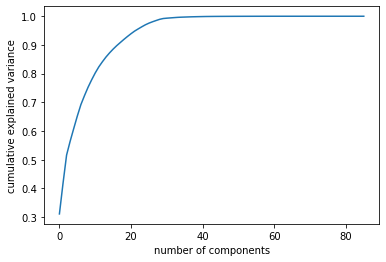

In [14]:
#PCA to minimize multicollinearity
pca = PCA().fit(df[list(feature_cols)])

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

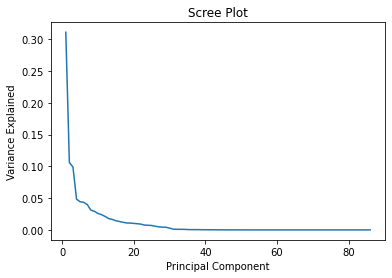

In [15]:
principal_components = np.arange(pca.n_components_)+1
plt.plot(principal_components, pca.explained_variance_ratio_)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [16]:
#apply dimensionality reduction to data, keeping n components
n_components = 20
pca=PCA(n_components=n_components)

df_ids_spreads = df[list(non_feature_cols)]

df_pca = pd.DataFrame(pca.fit_transform(df[list(feature_cols)]))
df_pca['GAME_ID'] = df_ids_spreads['GAME_ID']
df_pca['SPREAD'] = df_ids_spreads['SPREAD']
df_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,GAME_ID,SPREAD
0,10.222099,2.332947,-4.273636,-0.292252,-0.810581,-0.370772,1.082058,-2.406734,0.386082,-0.994921,...,-0.931262,0.777525,0.402825,0.833669,-0.619532,0.370432,1.388162,-0.774157,42100404,-10
1,10.402199,1.970282,-4.437071,-0.203187,-0.526464,-0.378201,0.992588,-2.433517,0.198686,-1.100421,...,-1.005607,0.758376,0.441769,0.871572,-0.754993,0.433928,1.465557,-0.765289,42100403,16
2,10.633668,-2.173903,-4.811731,-0.221056,0.441509,-0.081776,-1.118077,-2.264492,-0.392843,-0.974687,...,1.380044,-0.844712,0.342297,-0.565694,-0.810386,0.653899,-1.248783,-0.697126,42100402,19
3,10.654325,-1.860235,-4.926863,-0.020888,0.482518,-0.067391,-1.186489,-2.223086,-0.477871,-1.129575,...,1.455327,-0.866312,0.499304,-0.565634,-0.904381,0.674162,-1.297488,-0.627296,42100401,-12
4,8.513710,-3.235284,-4.733605,-1.310827,0.382388,0.303577,0.823990,-1.274405,0.338283,-1.384970,...,0.257681,0.409048,0.565381,-0.341341,-2.628038,0.906223,-2.151673,-1.023864,42100307,-4


In [17]:
#split pca data into train and test
test_game_ids = set(test_spreads_df['GAME_ID'])

train_pca = df_pca[~df_pca['GAME_ID'].isin(test_game_ids)].copy()
test_pca = df_pca[df_pca['GAME_ID'].isin(test_game_ids)].copy()

train_game_ids = train_pca['GAME_ID'].copy()
test_game_ids = test_pca['GAME_ID'].copy()

y_train_pca = train_pca['SPREAD']
X_train_pca = train_pca.drop(columns=['SPREAD','GAME_ID'])

y_test_pca = test_pca['SPREAD']
X_test_pca = test_pca.drop(columns=['SPREAD','GAME_ID'])

X_train_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
6246,10.592953,3.557452,-5.537966,-0.262974,-1.384510,0.443524,-1.767894,-2.347048,-2.586333,-0.458674,2.915115,-0.202886,-1.433540,1.889357,-0.885571,0.234021,1.054632,0.036175,0.654079,0.100478
6247,10.513532,-3.678944,-5.857229,-0.059259,1.327255,-0.035408,1.772669,-2.319271,2.745137,-0.634295,-2.824446,-0.319615,1.622215,-1.896850,-0.814521,-0.132818,1.062922,0.053132,-0.611369,-0.113291
6248,10.765944,-3.536339,-6.265462,-0.037060,1.234926,-0.286156,1.742109,-2.293294,2.559404,-0.640305,-2.815794,-0.201122,1.763877,-1.993516,-0.926041,-0.035169,1.111734,0.071343,-0.608939,0.108682
6249,10.498575,3.803192,-6.229778,-0.168332,-0.986119,-0.149401,-1.886127,-2.219021,-2.332706,-0.948541,3.064841,-0.335002,-1.981934,2.328138,-1.027210,-0.033564,1.270208,0.152326,0.587089,0.308731
6250,10.609427,3.151566,-6.445943,-0.308128,-1.407051,0.033888,-1.975615,-2.449335,-2.468752,-1.268476,2.787962,-0.331843,-1.838817,2.045060,-1.192526,0.166868,1.207823,0.195280,0.739628,0.381698


In [18]:
#polynomial regression
degree = 1
poly=PolynomialFeatures(degree)
X_train_poly = poly.fit_transform(X_train_pca)
X_test_poly = poly.fit_transform(X_test_pca)
poly_reg = LinearRegression()

poly_reg_baseline_score = cross_val_score(poly_reg, X_train_poly, y_train_pca, cv=5)
print('Polynomial regression baseline CV scores: ', poly_reg_baseline_score)
print('Polynomial regression baseline avg. CV score: ', poly_reg_baseline_score.mean())

Polynomial regression baseline CV scores:  [0.16630218 0.17770628 0.18772378 0.11500962 0.14345412]
Polynomial regression baseline avg. CV score:  0.15803919423783686


In [22]:
#evaluate baseline polynomical regression model
poly_reg = LinearRegression()
eval_model(poly_reg, X_train_poly, y_train_pca, X_test_poly, test_game_ids)

Winning percentage on book 1:  0.5048126503953249
Winning percentage on book 2:  0.5301204819277109
Winning percentage on book 4:  0.5172413793103449


In [23]:
#score on training and test data to check for overfitting
training_score = poly_reg.score(X_train_poly, y_train_pca)
test_score = poly_reg.score(X_test_poly, y_test_pca)

print('Training score: ', training_score)
print('Test score: ', test_score)

Training score:  0.16253690182650915
Test score:  0.13220293821361495


In [78]:
def eval_winnings(model, X_train, y_train, X_test, y_test, X_test_game_ids):
    #train model
    best_model.fit(X_train, y_train)
    
    #generate predictions with associated game ids
    predicts_df = pd.DataFrame({'SPREADS_PRED': model.predict(X_test)})
    predicts_df['GAME_ID'] = X_test_game_ids
    
    #create df with predicted spreads, actual spreads, and betting spreads
    winnings_eval_df = test_spreads_df.merge(predicts_df, how='inner', on='GAME_ID')
    winnings_eval_df = winnings_eval_df.merge(spreads_df, how='inner', on=['HOME_TEAM','GM_DATE'])
    
    winnings_eval_df.drop(columns=['SPREAD_1_HOME', 'SPREAD_2_HOME','SPREAD_3_HOME','SPREAD_4_HOME'], inplace=True)
    
    #convert betting spreads to floats
    winnings_eval_df['SPREAD_1_AWAY'] = winnings_eval_df['SPREAD_1_AWAY'].apply(convert_to_float)
    winnings_eval_df['SPREAD_2_AWAY'] = winnings_eval_df['SPREAD_2_AWAY'].apply(convert_to_float)
    winnings_eval_df['SPREAD_3_AWAY'] = winnings_eval_df['SPREAD_3_AWAY'].apply(convert_to_float)
    winnings_eval_df['SPREAD_4_AWAY'] = winnings_eval_df['SPREAD_4_AWAY'].apply(convert_to_float)
    
    #find betting spread with largest discrepency with predicted spread
    spread_away = np.empty(len(winnings_eval_df))
    odds_away = np.empty(len(winnings_eval_df))
    odds_home = np.empty(len(winnings_eval_df))
    
    for i, row in winnings_eval_df.iterrows():
        
        spread_diff = defaultdict(float)
        
        if row['SPREAD_1_AWAY'] is not None:
            spread_diff['SPREAD_1_AWAY'] = abs(row['SPREAD_1_AWAY'] - row['SPREADS_PRED'])
        if row['SPREAD_2_AWAY'] is not None:
            spread_diff['SPREAD_2_AWAY'] = abs(row['SPREAD_2_AWAY'] - row['SPREADS_PRED'])
        if row['SPREAD_3_AWAY'] is not None:
            spread_diff['SPREAD_3_AWAY'] = abs(row['SPREAD_3_AWAY'] - row['SPREADS_PRED'])
        if row['SPREAD_4_AWAY'] is not None:
            spread_diff['SPREAD_4_AWAY'] = abs(row['SPREAD_4_AWAY'] - row['SPREADS_PRED'])
        
        book_num = max(spread_diff, key=spread_diff.get)[7]
        
        print(i)
        if i==324:
            print(row)
            print(spread_diff)
            print(book_num)
        spread_away[i] = row['SPREAD_%s_AWAY'%book_num]
        odds_away[i] = row['ODDS_%s_AWAY'%book_num]
        odds_home[i] = row['ODDS_%s_AWAY'%book_num]
        
    winnings_eval_df.drop(columns=['SPREAD_1_AWAY',
                                   'ODDS_1_AWAY',
                                   'ODDS_1_HOME',
                                   'SPREAD_2_AWAY',
                                   'ODDS_2_AWAY',
                                   'ODDS_2_HOME',
                                   'SPREAD_3_AWAY',
                                   'ODDS_3_AWAY',
                                   'ODDS_3_HOME',
                                   'SPREAD_4_AWAY',
                                   'ODDS_4_AWAY',
                                   'ODDS_4_HOME',], inplace=True)
    
    winnings_eval_df['SPREAD_AWAY'] = spread_away
    winnings_eval_df['ODDS_AWAY'] = odds_away
    winnings_eval_df['ODDS_HOME'] = odds_home
    
    print(winnings_eval_df.head())
    
    '''
    #convert betting spread to float
    winnings_eval_df['AWAY_SPREAD'] = winnings_eval_df['AWAY_SPREAD'].apply(convert_to_float)
    
    #convert odds to ints
    new_odds_away = np.empty(len(winnings_eval_df))
    new_odds_home = np.empty(len(winnings_eval_df))
    for i, row in winnings_eval_df.iterrows():
        if row['ODDS_AWAY'][0] == '-':
            new_odds_away[i] = -int(row['ODDS_AWAY'][1:])
        elif row['ODDS_AWAY'][0] == '+':
            new_odds_away[i] = int(row['ODDS_AWAY'][1:])
        
        if row['ODDS_HOME'][0] == '-':
            new_odds_home[i] = -int(row['ODDS_HOME'][1:])
        elif row['ODDS_HOME'][0] == '+':
            new_odds_home[i] = int(row['ODDS_HOME'][1:])
        
    winnings_eval_df['ODDS_AWAY'] = new_odds_away
    winnings_eval_df['ODDS_HOME'] = new_odds_home
    
    print(winnings_eval_df.head())
    
    #initialize starting bankroll and bet amount
    bankroll = 1000
    bet_amt = 5
    
    bankroll_trended = [bankroll]
    
    #compute winnings
    for row in winnings_eval_df.iterrows():
        row = row[1]
        winnings = 0
        if row['SPREADS_PRED'] > row['AWAY_SPREAD']:
            if row['SPREAD'] < row['AWAY_SPREAD']:
                winnings = -bet_amt
            elif row['SPREAD'] > row['AWAY_SPREAD']:
                if row['ODDS_HOME'] < 0:
                    winnings = (100 / abs(row['ODDS_HOME'])) * bet_amt
                elif row['ODDS_HOME'] > 0:
                    winnings = (row['ODDS_HOME'] / 100) * bet_amt
                
        elif row['SPREADS_PRED'] < row['AWAY_SPREAD']:
            if row['SPREAD'] > row['AWAY_SPREAD']:
                winnings = -bet_amt
            elif row['SPREAD'] < row['AWAY_SPREAD']:
                if row['ODDS_AWAY'] < 0:
                    winnings = (100 / abs(row['ODDS_AWAY'])) * bet_amt
                elif row['ODDS_AWAY'] > 0:
                    winnings = (row['ODDS_AWAY'] / 100) * bet_amt
        
        bankroll += winnings
        bankroll_trended.append(bankroll)
    
    return bankroll_trended
    '''

In [79]:
#evaluate winnings from best model
best_model = LinearRegression()
bankroll_trended = eval_winnings(best_model, X_train_poly, y_train_pca, X_test_poly, y_test_pca, test_game_ids)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

ValueError: could not convert string to float: '-'

In [22]:
#implement ridge regression
#ridge regression did not significantly improve performance of baseline linear regression
'''
ridge_reg = Ridge()
alpha = np.logspace(1e-5, 1, 100)
grid = {'alpha' : alpha}

ridge_reg = GridSearchCV(estimator=ridge_reg, param_grid=grid, cv=5, verbose=5)
ridge_reg.fit(X_train_poly, y_train_pca)
print('Best score: ', ridge_reg.best_score_)
'''

"\nridge_reg = Ridge()\nalpha = np.logspace(1e-5, 1, 100)\ngrid = {'alpha' : alpha}\n\nridge_reg = GridSearchCV(estimator=ridge_reg, param_grid=grid, cv=5, verbose=5)\nridge_reg.fit(X_train_poly, y_train_pca)\nprint('Best score: ', ridge_reg.best_score_)\n"

In [23]:
#Random Forrest implementation
#Baseline RF CV results
'''
rf = RandomForestRegressor()
rf_score = cross_val_score(rf, X_train_pca, y_train_pca, cv=5)
print('Random Forest test scores: ', rf_score)
print('Random Forest avg. test score: ', rf_score.mean())
'''

"\nrf = RandomForestRegressor()\nrf_score = cross_val_score(rf, X_train_pca, y_train_pca, cv=5)\nprint('Random Forest test scores: ', rf_score)\nprint('Random Forest avg. test score: ', rf_score.mean())\n"

In [24]:
#evaluate baseline random forest betting results
'''
rf = RandomForestRegressor()
test_game_ids = test_spreads_df['GAME_ID']
eval_model(rf, X_train_pca, y_train_pca, X_test_pca, test_game_ids)
'''

"\nrf = RandomForestRegressor()\ntest_game_ids = test_spreads_df['GAME_ID']\neval_model(rf, X_train_pca, y_train_pca, X_test_pca, test_game_ids)\n"

In [25]:
#xgboost implementation
'''
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
xgb_predicts = xgb.predict(X_test)

print('XGBoost baseline: ', r2_score(y_test, xgb_predicts))
'''

"\nxgb = XGBRegressor()\nxgb.fit(X_train, y_train)\nxgb_predicts = xgb.predict(X_test)\n\nprint('XGBoost baseline: ', r2_score(y_test, xgb_predicts))\n"

In [26]:
#eval_model(xgb, X_train, y_train, X_test, test_game_ids)

In [27]:
#Tuned RF
#create hyperparameter grid

'''
rf = RandomForestRegressor()
n_estimators = [int(x) for x inn np.linspace(50, 500, num=10)]
max_features =['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 50, num=10)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 5]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, verbose=10, random_state=31, n_jobs=-1)

rf_random.fit(X_train, y_train)
'''

"\nrf = RandomForestRegressor()\nn_estimators = [int(x) for x inn np.linspace(50, 500, num=10)]\nmax_features =['auto', 'sqrt']\nmax_depth = [int(x) for x in np.linspace(10, 50, num=10)]\nmax_depth.append(None)\nmin_samples_split = [2, 5, 10]\nmin_samples_leaf = [1, 2, 5]\nbootstrap = [True, False]\n\nrandom_grid = {'n_estimators': n_estimators,\n               'max_features': max_features,\n               'max_depth': max_depth,\n               'min_samples_split': min_samples_split,\n               'min_samples_leaf': min_samples_leaf,\n               'bootstrap': bootstrap}\n\nrf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, verbose=10, random_state=31, n_jobs=-1)\n\nrf_random.fit(X_train, y_train)\n"